# 주제 : 흑백사진을 칼라로!
--------------
## 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
    - 이번 주제의 데이터는 protrait 데이터로 유명한 PFCN dataset을 이용합니다.
  ![PFCN dataset](https://www.researchgate.net/profile/Dawei_Li49/publication/334417334/figure/fig4/AS:832930272276492@1575597460956/Sample-images-from-the-PFCN-dataset.jpg)

     위의 이미지는 다음과 같은 것을 보여줍니다.  
    - 800x600의 사람 portrait 이미지  
     - ?????.png  
    - 사람 영역에 대한 흑백 portrait 이미지
     - ?????_matte.png
    - pfcn_original
     - 원본 800x600 이미지들
    - pfcn_small
     - colab용 100x75 이미지들



- 데이터 출처: 
 - [PFCN dataset](https://1drv.ms/u/s!ApwdOxIIFBH19Ts5EuFd9gVJrKTo)
 - [pfcn_small](https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing)

## 최종 목표

    - 작게 줄인 PFCN 데이터를 이용
    - 코렙에 구글 drive 연동
    - 큰 사진을 작게 줄이기
    - 이미지에 대한 오토인코더식 접근 방법
    - 칼라 사진을 흑백 사진으로 만드는 모델 이해
    - 흑백 사진을 칼라 사진으로 만드는 모델 이해

---


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


## Step 1. 도입전 기본 처리

### 구글 drive와 colab 연동

In [ ]:
# https://onedrive.live.com/?authkey=%21ADkS4V32BUmspOg&cid=F5111408123B1D9C&id=F5111408123B1D9C%2115035&parId=F5111408123B1D9C%2115033&action=locate

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!ls -al /gdrive/'My Drive'/'Colab Notebooks'/dataset/pfcn_original

total 10
-rw------- 1 root root 1556 Oct  7  2016 ReadMe.txt
drwx------ 2 root root 4096 Nov 13 09:32 testing
drwx------ 2 root root 4096 Nov 13 09:32 training


### pfcn 데이터

In [ ]:
# 데이터를 np array로 training에서 사람 이미지 한장을 불러오는 코드를 작성 (x로 변수 대입)
import imageio

x = imageio.imread("/gdrive/My Drive/Colab Notebooks/dataset/pfcn_original/training/00005.png")

### x와 shape을 출력

In [ ]:
# 데이터의 크기를 shape 함수를 통해 출력
x.shape

(800, 600, 3)

### x를 plt를 통하여 출력

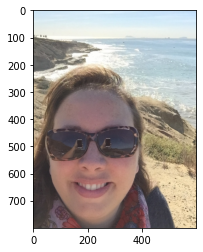

In [ ]:
# x를 plt를 이용하여 출력하는 코드를 작성
plt.imshow(x)
plt.show()

### (800, 600)의 의미지를 (100, 75)로 이미지를 줄이기

In [ ]:
# x를 (800, 600, 3) -> (100, 75, 3)로 줄이고 plt에서 확인하는 코드를 작성
from skimage.transform import resize
x1 = resize(x, (100, 75))
print(x.shape)
print(x1.shape)

(800, 600, 3)
(100, 75, 3)


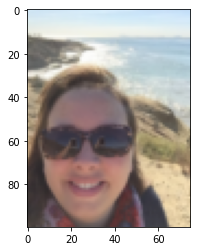

In [ ]:
plt.imshow(x1)
plt.show()

In [ ]:
import glob
glob.glob('/gdrive/My Drive/Colab Notebooks/dataset/pfcn_original/training/?????.png')[:5]

['/gdrive/My Drive/Colab Notebooks/dataset/pfcn_original/training/01201.png',
 '/gdrive/My Drive/Colab Notebooks/dataset/pfcn_original/training/01202.png',
 '/gdrive/My Drive/Colab Notebooks/dataset/pfcn_original/training/01205.png',
 '/gdrive/My Drive/Colab Notebooks/dataset/pfcn_original/training/01208.png',
 '/gdrive/My Drive/Colab Notebooks/dataset/pfcn_original/training/01206.png']

In [ ]:
!ls -al /gdrive/'My Drive'/'Colab Notebooks'/dataset/

total 304074
-rw------- 1 root root 173961605 Dec 17 13:41 celeba_small.npz
drwx------ 2 root root      4096 Dec 19 05:40 new
drwx------ 4 root root      4096 Dec 17 23:44 pfcn_original
-rw------- 1 root root 137288603 Nov 13 11:53 pfcn_small.npz
-rw------- 1 root root    113072 Sep 22 12:22 texture.jpg


### pfcn_small.npz 데이터에서 학습, 테스트 데이터를 로드

In [ ]:
# pfcn_small.npz에서 train_images, test_images를 np array로 로드
pfcn_small = np.load('/gdrive/My Drive/Colab Notebooks/dataset/pfcn_small.npz')

In [ ]:
list(pfcn_small.keys())
train_images = pfcn_small['train_images']
test_images = pfcn_small['test_images']

### train_images에서 0이 아닌 값들을 출력

In [ ]:
# 하나의 이미지에 대한 모든 0이 아닌 값을 출력하는 코드를 작성
train_images[train_images != 0][:2]

array([0.23627451, 0.34803922])

### train_images의 dtype을 출력

In [ ]:
# dtype을 이용하여 이미지의 np array type을 확인
print(train_images.dtype)
print(len(train_images))


float64
1700


## Step 2. 전처리

### train/test 이미지 데이터의 범위 확인

In [ ]:
#  test_images shape과 dtype, 0이 아닌 숫자를 출력하는 코드를 작성
print( train_images.shape, test_images.shape )



(1700, 100, 75, 3) (300, 100, 75, 3)
True True


In [ ]:
train_images[train_images != 0], test_images[test_images != 0]

(array([0.23627451, 0.34803922, 0.64705882, ..., 0.05588235, 0.0245098 ,
        0.01470588]),
 array([0.50980392, 0.64117647, 0.64313725, ..., 0.32745098, 0.47058824,
        0.38627451]))

In [ ]:
train_images.dtype, test_images.dtype

(dtype('float64'), dtype('float64'))

### train/test 이미지 데이터의 최소/최대값을 출력

In [ ]:
# train/test 전체 데이터에서 min, max를 출력하는 코드를 작성
print(train_images.min(), train_images.max())
print(test_images.min(), test_images.max())

0.0 1.0
0.0 1.0


### train_images와 test_images로 흑백인 train_gray_images, test_gray_images를 생성

In [ ]:
# train_images와 test_images로 흑백인 train_gray_images, test_gray_images를 생성
from skimage import color

train_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images])
test_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images])

print(train_gray_images.shape, test_gray_images.shape)

(1700, 100, 75, 1) (300, 100, 75, 1)


## Step 3. 시각화 방법

### train_image의 이미지를 5장 획득하여 (5, 100, 75, 3)의 shape을 출력

In [ ]:
# (배치, 100, 75, 3)인 train_images에서 (5, 100, 75, 3)을 획득하는 코드를 작성
train_images[:5].shape

(5, 100, 75, 3)

### 획득한 5장의 의미지를 (100, 75 * 5, 3)의 shape으로 변경

In [ ]:
# np.hstack은 height 방향의 배열을 풀어서 width 방향으로 연결
# 해당 기능을 쓰면 (height, image_height, image_width, color)의 shape을 (image_height, image_width * height, color)으로 변경 가능
np.hstack(train_images[:5])

(100, 375, 3)

In [ ]:
train_images[:5].transpose((1,0,2,3)).reshape((100, -1, 3)).shape

(100, 375, 3)

In [ ]:
train_images[:5].reshape((100, 375, 3)).shape

(100, 375, 3)

### (100, 375, 3)이 된 tensor를 plt로 출력

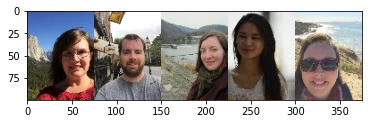

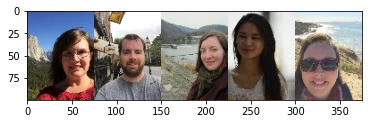

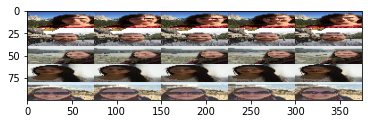

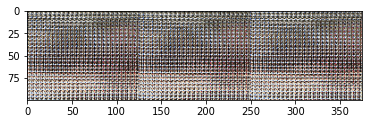

In [ ]:
# (28, 140, 3)의 이미지를 plt로 출력
plt.imshow(np.hstack(train_images[:5]))
plt.show()
plt.imshow(train_images[:5].transpose((1,0,2,3)).reshape((100, -1, 3)))
plt.show()
plt.imshow(train_images[:5].reshape((100, 375, 3)))
plt.show()
plt.imshow(train_images[:5].transpose((2,1,0,3)).reshape((100, -1, 3)))
plt.show()

### gray도 (100, 375)으로 plt로 출력

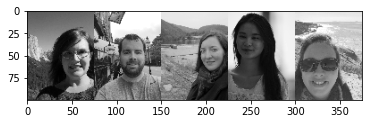

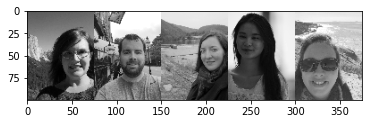

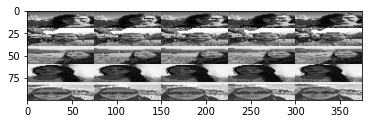

In [ ]:
# (28, 140, 1)의 이미지를 plt로 출력
plt.imshow(np.hstack(train_gray_images[:5][...,0]), cmap="gray")
plt.show()

plt.imshow(train_gray_images[:5][...,0].transpose((1,0,2)).reshape((100, -1)), cmap="gray")
plt.show()
plt.imshow(train_gray_images[:5][...,0].reshape((100, 375)), cmap="gray")
plt.show()

## Step 4. 흑백 -> 칼라 모델링

### 흑백 이미지를 칼라로 변환하는 모델을 작성

In [ ]:
# input (100, 75, 1), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def unet_color():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

### 모델을 할당 받고 서머리를 출력

In [ ]:
# unet_color() 모델을 할당 받고 서머리를 출력하는 코드를 작성
model = unet_color()
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 100, 75, 16)  160         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 100, 75, 16)  64          conv2d_168[0][0]                 
__________________________________________________________________________________________________
activation_164 (Activation)     (None, 100, 75, 16)  0           batch_normalization_164[0][0]    
____________________________________________________________________________________________

### 만든 모델에 로스와 옵티마이저, 메트릭을 설정

In [ ]:
# 만든 모델에 loss는 mse, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성
model.compile(loss = "mse", optimizer="adam", metrics=["accuracy"])

### 만든 모델에 train_gray_images, train_images를 학습

In [ ]:
# train_gray_images 학습시키고 5 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성
hist = model.fit(train_gray_images, train_images, validation_data=(test_gray_images, test_images), epochs=50, verbose=1)

Epoch 1/50
54/54 [==============================] - 5s 62ms/step - loss: 0.0469 - accuracy: 0.2460 - val_loss: 0.0685 - val_accuracy: 0.6486
Epoch 2/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0119 - accuracy: 0.5150 - val_loss: 0.0616 - val_accuracy: 0.6741
Epoch 3/50
54/54 [==============================] - 3s 50ms/step - loss: 0.0094 - accuracy: 0.5777 - val_loss: 0.0526 - val_accuracy: 0.6431
Epoch 4/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0082 - accuracy: 0.6019 - val_loss: 0.0439 - val_accuracy: 0.6575
Epoch 5/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0079 - accuracy: 0.6097 - val_loss: 0.0419 - val_accuracy: 0.4160
Epoch 6/50
54/54 [==============================] - 3s 50ms/step - loss: 0.0078 - accuracy: 0.6158 - val_loss: 0.0309 - val_accuracy: 0.6817
Epoch 7/50
54/54 [==============================] - 3s 50ms/step - loss: 0.0077 - accuracy: 0.6512 - val_loss: 0.0238 - val_accuracy: 0.6244
Epoch 8/50
54

### 학습 진행 사항을 plt으로 출력

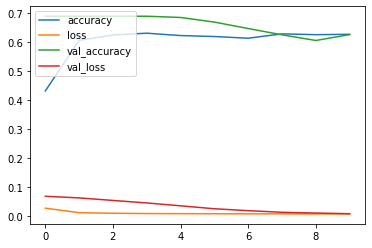

In [ ]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

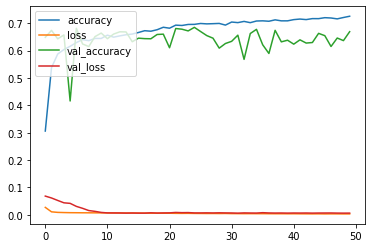

In [ ]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

## Step 5. 칼라 모델 결과 확인

### 완성된 모델에서 test_gray_images를 1장 넣고 결과를 res 변수에 저장

In [ ]:
# 모델에 test_gray_images 중 1장을 넣고 결과를 받는 코드를 작성
res = model.predict(test_gray_images[1:2])
print(test_gray_images[1:2].shape)
print(res.shape)


(1, 100, 75, 1)
(1, 100, 75, 3)


### res와 test_images[1]를 width 방향으로 결합하여 plt로 출력

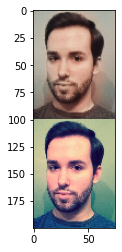

In [ ]:
# res와 test_images[1]를 width 방향으로 결합하여 (100, 75 * 3, 3) 의 이미지를 만들어 plt로 출력하는 코드를 작성
plt.imshow(np.concatenate([res[0], test_images[1]]))

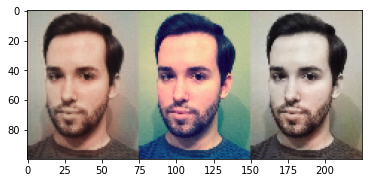

In [ ]:
plt.imshow(np.concatenate([res[0], test_images[1], model.predict(test_gray_images[1:2])[0]], axis=1))

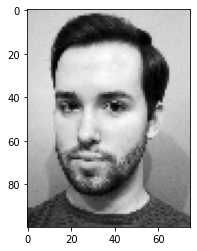

In [ ]:
plt.imshow(test_gray_images[1][...,0], cmap="gray")

### 5장의 test_gray_images를 모델에 넣은 뒤 결과를 29 방식으로 비교

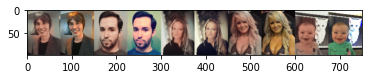

In [ ]:
# 5장의 이미지를 모델에 넣고 결과를 29번과 같은 방식으로 비교하는 코드를 작성
five = model.predict(test_gray_images[:5])
plt.imshow(np.concatenate([five, test_images[:5]], axis=2).transpose((1,0,2,3)).reshape((100, -1,3)))

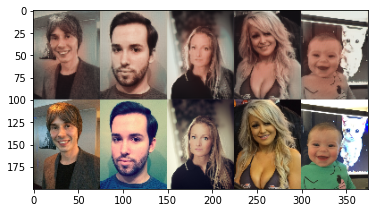

In [ ]:
five = model.predict(test_gray_images[:5])
plt.imshow(np.concatenate([five, test_images[:5]], axis=1).transpose((1,0,2,3)).reshape((200, -1,3)))

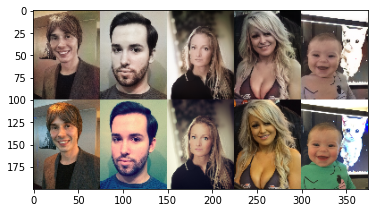

In [ ]:
five = model.predict(test_gray_images[:5])
plt.imshow(np.concatenate([five, test_images[:5]], axis=1).transpose((1,0,2,3)).reshape((200, -1,3)))

## Step 6. lab 칼라 모델링

### rgb 칼라를 lab 칼라로 변경 (위의 color 모델이 잘못된 것은 아님)

In [ ]:
# rgb2lab을 이용하여 rgb 칼라를 lab 칼라로 바꾸는 코드를 작성
train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

### lab 칼라 이미지를 채널별로 최대, 최소 값을 출력

In [ ]:
# lab 칼라 이미지를 채널별로 최대, 최소 값을 출력하는 코드를 작성
print(train_lab_images[..., 0].min(), train_lab_images[..., 0].max())
print(train_lab_images[..., 1].min(), train_lab_images[..., 1].max())
print(train_lab_images[..., 2].min(), train_lab_images[..., 2].max())

0.0 100.0
-78.53736435567544 86.20773183914271
-91.97308466277427 93.80664030542576


### lab 칼라는 채널별 최대값은 [0-100, +-128, +-128]. 0-1 노말라이즈

In [ ]:
# lab 칼라를 노말라이즈 하는 코드를 작성
a = train_lab_images + [0, 128, 128]
print(a[...,0].min(), a[...,0].max())
print(a[...,1].min(), a[...,1].max())
print(a[...,2].min(), a[...,2].max())

b = a / [100., 255., 255.]
print(b[...,0].min(), b[...,0].max())
print(b[...,1].min(), b[...,1].max())
print(b[...,2].min(), b[...,2].max())


#0 ~ 100   + 0 => 0 ~ 100   / 100   => 0~1
#-128 + 127 + 128 => 0 ~ 255 / 255 => 0~1
#-128 + 127 + 128 => 0 ~ 255 / 255 => 0~1


0.0 100.0
49.462635644324564 214.2077318391427
36.02691533722573 221.80664030542576
0.0 1.0
0.19397112017382181 0.8400303209378145
0.141282020930297 0.8698299619820618


In [ ]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100., 255., 255.]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100., 255., 255.]

In [ ]:
print(train_lab_images[...,0].min(), train_lab_images[...,0].max())
print(train_lab_images[...,1].min(), train_lab_images[...,1].max())
print(train_lab_images[...,2].min(), train_lab_images[...,2].max())


0.0 1.0
0.19397112017382181 0.8400303209378145
0.141282020930297 0.8698299619820618


### lab 칼라의 이미지 하나를 고르고 첫번째 채널을 plt으로 출력


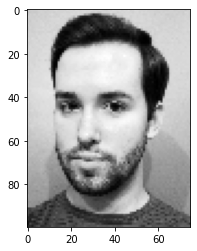

In [ ]:
# lab 칼라 이미지의 첫번째 채널을 plt로 출력하는 코드를 작성
plt.imshow(test_lab_images[1][...,0], cmap="gray")
plt.show()     


# model1(grayscale x) -> r?g?b?
# model2(L x) -> a?b? => Lx+a?b? -> rgb

# grayscale x =>   r ?, g ?, b ?
# L x =>           a ?, b ? 

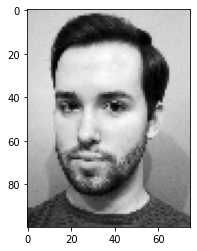

In [ ]:
plt.imshow(test_gray_images[1][...,0], cmap="gray")
plt.show()

### lab 칼라 첫번째 채널로 나머지 2채널을 예측하는 모델을 작성

In [ ]:
# input (100, 75, 1), output (100, 75, 2)을 처리할 수 있는 모래시계 모양의 모델을 작성
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def unet_lab():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)
    
    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(2, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

### 모델을 할당 받고 서머리를 출력

In [ ]:
# unet_lab() 모델을 할당 받고 서머리를 출력하는 코드를 작성
model2 = unet_lab()
model2.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, 100, 75, 16)  160         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 100, 75, 16)  64          conv2d_187[0][0]                 
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 100, 75, 16)  0           batch_normalization_182[0][0]    
____________________________________________________________________________________________

### 만든 모델에 로스와 옵티마이저, 메트릭을 설정

In [ ]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성
model2.compile(loss="mae", optimizer="adam", metrics=["accuracy"])

### 만든 모델에 train_lab_images[...,0], train_lab_images[...,1:]를 학습

In [ ]:
# train_lab_images[...,0], 학습시키고 50 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성
hist = model2.fit(train_lab_images[...,0:1], train_lab_images[...,1:], validation_data=(test_lab_images[...,0:1], test_lab_images[...,1:]), epochs=50, verbose=1)

Epoch 1/50
54/54 [==============================] - 5s 57ms/step - loss: 0.0898 - accuracy: 0.5519 - val_loss: 0.1665 - val_accuracy: 0.4765
Epoch 2/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0358 - accuracy: 0.5887 - val_loss: 0.0403 - val_accuracy: 0.5922
Epoch 3/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0343 - accuracy: 0.5997 - val_loss: 0.0749 - val_accuracy: 0.5536
Epoch 4/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0340 - accuracy: 0.5921 - val_loss: 0.0565 - val_accuracy: 0.5837
Epoch 5/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0336 - accuracy: 0.6058 - val_loss: 0.0520 - val_accuracy: 0.5705
Epoch 6/50
54/54 [==============================] - 3s 49ms/step - loss: 0.0341 - accuracy: 0.6098 - val_loss: 0.0438 - val_accuracy: 0.5907
Epoch 7/50
54/54 [==============================] - 3s 50ms/step - loss: 0.0330 - accuracy: 0.6115 - val_loss: 0.0359 - val_accuracy: 0.5992
Epoch 8/50
54

### 학습 진행 사항을 plt으로 출력

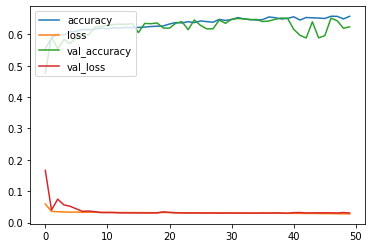

In [ ]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

## Step 7. lab 칼라 모델 결과 확인

### 완성된 모델에서 흑백이미지 1장 넣고 결과를 res 변수에 저장

In [ ]:
# 모델에 흑백이미지 중 1장을 넣고 결과를 받는 코드를 작성
res = model2.predict(test_lab_images[1:2][...,0:1])

### res와 test_lab_images[...,1:]를 width 방향으로 결합하여 plt로 출력

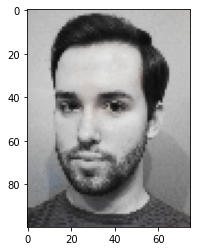

In [ ]:
# res와 test_images[1]를 width 방향으로 결합하여 (100, 75 * 3, 3) 의 이미지를 만들어 plt로 출력하는 코드를 작성
def l2rgb(l):
    pred_ab = model2.predict(np.expand_dims(l, 0))
    pred_img = np.zeros((100, 75, 3))

    pred_img[:,:,0] = l.reshape((100,75))
    pred_img[:,:,1:] = pred_ab[0]
    
    pred_lab = (pred_img * [100, 255, 255]) - [0, 128, 128]
    rgb_img = color.lab2rgb(pred_lab)
    return rgb_img


plt.imshow(  l2rgb(test_lab_images[1][...,0]) )

### 5장의 test_lab_images를 모델에 넣은 뒤 결과를 29 방식으로 비교

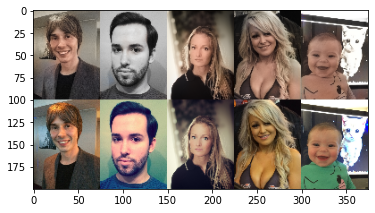

In [ ]:
# 5장의 이미지를 모델에 넣고 결과를 29번과 같은 방식으로 비교하는 코드를 작성

five = np.array( [ l2rgb(img) for img in test_lab_images[:5][...,0] ] )
plt.imshow(np.concatenate([five, test_images[:5]], axis=1).transpose((1,0,2,3)).reshape((200, -1,3)))


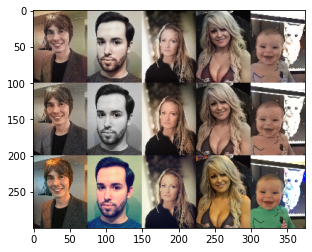

In [ ]:
five1 = model.predict(test_gray_images[:5])
five2 = np.array( [ l2rgb(img) for img in test_lab_images[:5][...,0] ] )
plt.imshow(np.concatenate([five1, five2, test_images[:5]], axis=1).transpose((1,0,2,3)).reshape((300, -1,3)))

## Step 8. 모델 저장 및 로드, 다운

### 모델을 저장

In [ ]:
# 모델을 저장하는 코드를 작성
model2.save('./lecture006.h5')

In [ ]:
!ls -alh

total 23M
drwxr-xr-x 1 root root 4.0K Jan 16 08:08 .
drwxr-xr-x 1 root root 4.0K Jan 16 08:08 ..
drwxr-xr-x 1 root root 4.0K Jan  8 17:11 .config
-rw-r--r-- 1 root root  23M Jan 16 08:08 lecture006.h5
drwxr-xr-x 1 root root 4.0K Jan  6 18:10 sample_data


### 모델 파일을 새로운 모델에 로드

In [ ]:
# 모델을 로드하는 코드를 작성
new_model = tf.keras.models.load_model('./lecture006.h5')
new_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, 100, 75, 16)  160         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 100, 75, 16)  64          conv2d_187[0][0]                 
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 100, 75, 16)  0           batch_normalization_182[0][0]    
____________________________________________________________________________________________

### 로드한 모델을 test 데이터로 평가


In [ ]:
# 로드한 모델을 test 데이터로 평가
loss, acc = new_model.evaluate(test_lab_images[...,0], test_lab_images[...,1:], verbose=1)
print(loss, acc)

10/10 [==============================] - 1s 19ms/step - loss: 0.0306 - accuracy: 0.6238
0.030649233609437943 0.6237773299217224
